# Titanic Competition from Kaggle

The "Titanic: Machine Learning from Disaster" is a good competition to get started with ML hands-on. So, for beginners in ML I highly recommend it a try.

I created this code using python to predict the survival labels for the test set in this competition. The highest score I got was 0.77990 for the accuracy of the model. In the following paragraphs I will present the steps I went through to get this score.

**Note:** Keep in mind that this tutorial is just as a simple starting point and will be useful for beginners. Many more explorations and optimizations could be done. If you have any comments about this tutorial please let me know. 

In this tutorial I will present basic steps of a data science pipeline:

#### 1. Data exploration and visualization  
   - Explore dataset
   - Choose important features and visualize them according to survival/non-survival
   
#### 2. Data cleaning, Feature selection and Feature engineering
   - Null values
   - Encode categorical data
   - Transform features
   
#### 3. Test different classifiers 
   - Logistic Regression (LR)
   - K-NN
   - Support Vector Machines (SVM)
   - Naive Bayes
   - Random Forest (RF)
 
 

First let's start by importing the essential libraries to work with dataframes (**pandas**), numeric values (**numpy**) and visualization (**matplotlib.pyplot**).

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Now let's import the csv file with the training dataset. You can download it from [here](https://www.kaggle.com/c/titanic/data).  The explanation of the features (each column from the dataset) is also presented in this link. 

In [4]:
dataset= pd.read_csv("input/train.csv")

## 1. Data exploration and visualization  

For a good start, we should look at the dataset. Analyze the features and think which could be useful to predict the survival rate. The features that probably may have an influence are: the **"P-class"** (expect to see more survival for higher class), the **"Sex"** and **"Age"** ("women and children first"), and let's say **"Embarked"** also. 

We will now plot some graphs to confirm if these features show some relation with the survival rate. These plots were based in the graphs presented [here](http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html).  

Percentage of Class 1 that survived: 63.0 %
Percentage of Class 2 that survived: 47.0 %
Percentage of Class 3 that survived: 24.0 %


,1,2,3
Survived,136,87,119
Died,80,97,372


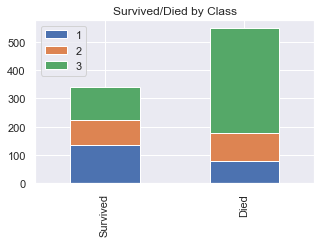

In [5]:
%matplotlib inline
import seaborn
seaborn.set() 

#-------------------Survived/Died by Class -------------------------------------
survived_class = dataset[dataset['Survived']==1]['Pclass'].value_counts()
dead_class = dataset[dataset['Survived']==0]['Pclass'].value_counts()
df_class = pd.DataFrame([survived_class,dead_class])
df_class.index = ['Survived','Died']
df_class.plot(kind='bar',stacked=True, figsize=(5,3), title="Survived/Died by Class")

Class1_survived= df_class.iloc[0,0]/df_class.iloc[:,0].sum()*100
Class2_survived = df_class.iloc[0,1]/df_class.iloc[:,1].sum()*100
Class3_survived = df_class.iloc[0,2]/df_class.iloc[:,2].sum()*100
print("Percentage of Class 1 that survived:" ,round(Class1_survived),"%")
print("Percentage of Class 2 that survived:" ,round(Class2_survived), "%")
print("Percentage of Class 3 that survived:" ,round(Class3_survived), "%")

# display table
from IPython.display import display
display(df_class)

In [ ]:
#-------------------Survived/Died by SEX------------------------------------
   
Survived = dataset[dataset.Survived == 1]['Sex'].value_counts()
Died = dataset[dataset.Survived == 0]['Sex'].value_counts()
df_sex = pd.DataFrame([Survived , Died])
df_sex.index = ['Survived','Died']
df_sex.plot(kind='bar',stacked=True, figsize=(5,3), title="Survived/Died by Sex")


female_survived= df_sex.female[0]/df_sex.female.sum()*100
male_survived = df_sex.male[0]/df_sex.male.sum()*100
print("Percentage of female that survived:" ,round(female_survived), "%")
print("Percentage of male that survived:" ,round(male_survived), "%")

# display table
from IPython.display import display
display(df_sex) 

In [ ]:
#-------------------- Survived/Died by Embarked ----------------------------

survived_embark = dataset[dataset['Survived']==1]['Embarked'].value_counts()
dead_embark = dataset[dataset['Survived']==0]['Embarked'].value_counts()
df_embark = pd.DataFrame([survived_embark,dead_embark])
df_embark.index = ['Survived','Died']
df_embark.plot(kind='bar',stacked=True, figsize=(5,3))

Embark_S= df_embark.iloc[0,0]/df_embark.iloc[:,0].sum()*100
Embark_C = df_embark.iloc[0,1]/df_embark.iloc[:,1].sum()*100
Embark_Q = df_embark.iloc[0,2]/df_embark.iloc[:,2].sum()*100
print("Percentage of Embark S that survived:", round(Embark_S), "%")
print("Percentage of Embark C that survived:" ,round(Embark_C), "%")
print("Percentage of Embark Q that survived:" ,round(Embark_Q), "%")

from IPython.display import display
display(df_embark)

## 2. Data cleaning, Feature selection and Feature engineering
The preprocessing of the data is a quite crucial part. If we just give the dataset without cleaning it, most probably the results will not be good! So, in this step we will preprocess the training dataset and this will involve feature selection, data cleaning, and feature engineering.   

I will start with feature selection. As we saw previously, **"P-Class", "Sex", "Age"** and **"Embarked"** showed some relation with Survived rate. Thus, I will drop the remaining features, except **"Name"** because it will be useful in a further step of the cleaning process. 

In [ ]:
X = dataset.drop(['PassengerId','Cabin','Ticket','Fare', 'Parch', 'SibSp'], axis=1)
y = X.Survived                       # vector of labels (dependent variable)
X=X.drop(['Survived'], axis=1)       # remove the dependent variable from the dataframe X

X.head(20)

We can see, from this displayed DataFrame, that **"Sex"** and **"Embarked"** are categorical features and have strings instead of numeric values. We need to encode these strings into numeric data, so the algorithm can perform its calculations. 

For the **"Sex"** feature we can use the **LabelEncoder** class from  **sklearn.preprocessing** library. 

Another way of doing this is by using the **get_dummies** from **pandas**. We will be using this to encode the **"Embarked"** feature. But first, as **"Embarked"** has two NaN values we need to take care of these missing values. In this approach, I will provide the 'S' category because it is the most frequent in the data. After this, it is then possible to use the **get_dummies** and get three new columns (Embarked_C,	Embarked_Q, Embarked_S) which are called dummy variables (they assign ‘0’ and ‘1’ to indicate membership in a category). The previous **"Embarked"** can be dropped from X as it will not be needed anymore and we can now concatenate the X dataframe with the new **"Embarked"** which has the three dummy variables. Finally, as the number of dummy variables necessary to represent a single feature is equal to the number of categories in that feature minus one, we can remove one of the dummies created, lets say Embarked_S, for example. This will not remove any information because by having the values from Embarked_C and	Embarked_Q the algorithm can easily understand the values from the remaining dummy variable (when Embarked_C and Embarked_Q are '0' Embarked_S will be '1', otherwise it will be '0').  

In [ ]:
# ----------------- Encoding categorical data -------------------------

# encode "Sex"
from sklearn.preprocessing import LabelEncoder
labelEncoder_X = LabelEncoder()
X.Sex=labelEncoder_X.fit_transform(X.Sex)


# encode "Embarked"

# number of null values in embarked:
print ('Number of null values in Embarked:', sum(X.Embarked.isnull()))

# fill the two values with one of the options (S, C or Q)
row_index = X.Embarked.isnull()
X.loc[row_index,'Embarked']='S' 

Embarked  = pd.get_dummies(  X.Embarked , prefix='Embarked'  )
X = X.drop(['Embarked'], axis=1)
X= pd.concat([X, Embarked], axis=1)  
# we should drop one of the columns
X = X.drop(['Embarked_S'], axis=1)

X.head()

You may wonder why are we still keeping the **"Name"** column. In fact the name does not seem to have influence, it does not matter if a person is named Owen or William, however this column has the title located after the Surname and the comma ("Mr", "Mrs", "Miss", etc.) which can be useful.  

If we take a look at the table X displayed previously we can see many missing values for the **"Age"** column. Removing these rows with missing values would involve removing 177 rows (which is quite a lot!) and we would have less information to create the model. In some cases, it is acceptable to take the average of the column and replace the null values, nonetheless in this case, it is possible to estimate the age of the person by their title, present in the **"Name"** column.   

Therefore, I will first identify the different titles presented and then average the Age for each title. We can provide this averaged Age found for each title to the people with missing Age values, accordingly to their title in **"Name"**. 

After using the information in **"Name"** we can drop this column. 

In [ ]:
#-------------- Taking care of missing data  -----------------------------

print ('Number of null values in Age:', sum(X.Age.isnull()))
 

# -------- Change Name -> Title ----------------------------
got= dataset.Name.str.split(',').str[1]
X.iloc[:,1]=pd.DataFrame(got).Name.str.split('\s+').str[1]
# ---------------------------------------------------------- 


#------------------ Average Age per title -------------------------------------------------------------
ax = plt.subplot()
ax.set_ylabel('Average age')
X.groupby('Name').mean()['Age'].plot(kind='bar',figsize=(13,8), ax = ax)

title_mean_age=[]
title_mean_age.append(list(set(X.Name)))  #set for unique values of the title, and transform into list
title_mean_age.append(X.groupby('Name').Age.mean())
title_mean_age
#------------------------------------------------------------------------------------------------------


#------------------ Fill the missing Ages ---------------------------
n_traning= dataset.shape[0]   #number of rows
n_titles= len(title_mean_age[1])
for i in range(0, n_traning):
    if np.isnan(X.Age[i])==True:
        for j in range(0, n_titles):
            if X.Name[i] == title_mean_age[0][j]:
                X.Age[i] = title_mean_age[1][j]
#--------------------------------------------------------------------    

X=X.drop(['Name'], axis=1)

       

We can also make feature transformation. For example, we could transform the **"Age"** feature in order to simplify it. We could distinguish the youngsters (age less than 18 years) from the adults.  



In [ ]:
for i in range(0, n_traning):
    if X.Age[i] > 18:
        X.Age[i]= 0
    else:
        X.Age[i]= 1

X.head()

Now, we can say that we have a quite well clean dataset to provide to our classifier algorithm. 


## 3. Test different classifiers


Having the data preprocessed we can now provide the data to different classifiers and see which one performs better in creating a model of classification for this data. 

We will use cross validation, which is a model validation technique to evaluate how well a model will generalize to an independent data set. Python has the **cross_val_score** class from **sklearn.model_selection** library to perform cross validation. 

In [ ]:
#-----------------------Logistic Regression---------------------------------------------
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l2',random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Logistic Regression:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")



#-----------------------------------K-NN --------------------------------------------------

# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("K-NN:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")


#---------------------------------------SVM -------------------------------------------------

# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("SVM:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")


#---------------------------------Naive Bayes-------------------------------------------

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Naive Bayes:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")



#----------------------------Random Forest------------------------------------------

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Random Forest:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std())


As we can see, from all the 5 classifiers tested in this tutorial, **Random Forest** got better results. 

After changing the test set by performing the same transformations done in the training set we can then use the **Random Forest** model created and do the predictions. The submission of these predictions was scored 0.77990 in Kaggle.  

Hope this tutorial was useful in some way. For a more detailed tutorial in the Titanic challenge I recommend this [tutorial](http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html).  